# <font color=#CC3971><center>**PARTICIPEZ A LA CONCEPTION D'UNE VOITURE AUTONOME**</center></font>
# <font color=#FCF57C><center>**Structure des données et analyse exploratoire**</center></font>

# <font color=salmon>PART 1 - RAPPEL DU CONTEXTE PROJET</font>

## **<font color=green>Le projet</font>**

Notre projet consiste à **concevoir, entraîner et déployer un modèle de segmentation d'images**, qui s'intégrera facilement dans la chaîne complète du système embarqué d'une voiture autonome :
1. l'acquisition des images en temps réel ;
2. le traitement des images ;
3. la **segmentation des images**; 
4. et enfin, le système de décision.

## **<font color=green>Le jeu de données</font>**

Nous allons travailler avec le jeu de données [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/):
- 2380 images et masques annotés dans le Train Set;
- 595 images et masques annotés dans le Validation Set;
- 500 images et masques annotés dans le Test Set.

# <font color=salmon>PART 2 - LIBRAIRIES, PARAMETRES, HELPERS</font>

## **<font color=green>Chargement des librairies</font>**

In [1]:
import pandas as pd
import numpy as np
import os, glob
import random
from time import time
import tqdm
import six
from collections import namedtuple

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

print("Tensorflow version " + tf.__version__)
print("OpenCV " + cv2.__version__)

Tensorflow version 2.7.0
OpenCV 4.1.2


## **<font color=green>Chargement des données</font>**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set all paths to folders: project, model, images, masks
project_path = '/content/drive/MyDrive/OC_IA/P08/V1'
model_path = '/content/drive/MyDrive/OC_IA/P08/V1/model'
checkpoint_path = '/content/drive/MyDrive/OC_IA/P08/V1/checkpoints'
train_input_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/train/images'
train_mask_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/train/masks30'
train_target_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/train/masks'
val_input_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/val/images'
val_mask_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/val/masks30'
val_target_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/val/masks'
test_input_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/test/images'
test_mask_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/test/masks30'
test_target_dir = '/content/drive/MyDrive/OC_IA/P08/V1/dataset/test/masks'

In [4]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path),
      ' - Number of target (8 categories): ', len(train_target_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path),
      ' - Number of target (8 categories): ', len(val_target_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
test_target_path = sorted(glob.glob(test_target_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path),
      ' - Number of target (8 categories): ', len(test_target_path))
print(test_input_path[0])

TRAIN -- Number of images:  2380  - Number of original masks:  2380  - Number of target (8 categories):  2380
/content/drive/MyDrive/OC_IA/P08/V1/dataset/train/images/aachen_000000_000019.png

TRAIN -- Number of images:  595  - Number of original masks:  595  - Number of target (8 categories):  595
/content/drive/MyDrive/OC_IA/P08/V1/dataset/val/images/stuttgart_000104_000019.png

TRAIN -- Number of images:  500  - Number of original masks:  500  - Number of target (8 categories):  500
/content/drive/MyDrive/OC_IA/P08/V1/dataset/test/images/frankfurt_000000_000294.png


### **Package : Image Segmentation Keras - Divam Gupta**

Pour la suite de notre expérimentation, nous allons utiliser un dépôt GitHub qui nous permettra **d'accélerer la sélection du modèle adapté à notre use-case**.

**Auteur du dépôt GitHub** : [**Divam Gupta**](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html)

In [5]:
from IPython.display import clear_output
!pip install --upgrade git+https://github.com/tysonjohn015/image-segmentation-keras.git
!pip install git+https://github.com/aleju/imgaug.git
clear_output()

from keras_segmentation.models.fcn import fcn_8_mobilenet
from keras_segmentation.models.unet import vgg_unet
from keras_segmentation.models.segnet import mobilenet_segnet

from imgaug import augmenters as iaa

## **<font color=green>Paramètres de modèle</font>**

In [6]:
# Set parameters & hyperparameters
img_height, img_width = 256, 512
img_size = (img_height, img_width)
batch_size = 16
n_classes = 8
samples = len(train_input_path)
optimizer = 'adam'
loss='categorical_crossentropy'
score_IoU = tf.keras.metrics.MeanIoU(num_classes=8,
                                     name='mean_IoU')
epochs = 10
epochs_optim = 3

### **Dataframe de sauvegarde des résultats**

In [7]:
# Append model's result to dataframe
def model_result_to_dataframe(model_name, epochs, training_time, eval_time, 
                              df_result, model_result, do_augment=False):

    if do_augment==True:
        model_name = (f'augmented_{model_name}')

    df_result =df_result.append(
        {'model':model_name,
         'epoch': epochs,
         'training_time':training_time,
         'eval_time':eval_time,
         'freq_weighted_IoU':model_result["frequency_weighted_IU"],
         'mean_IoU':model_result["mean_IU"],
         'void_IoU':model_result["class_wise_IU"][0],
         'flat_IoU':model_result["class_wise_IU"][1],
         'construction_IoU':model_result["class_wise_IU"][2],
         'object_IoU':model_result["class_wise_IU"][3],
         'nature_IoU':model_result["class_wise_IU"][4],
         'sky_IoU':model_result["class_wise_IU"][5],
         'human_IoU':model_result["class_wise_IU"][6],
         'vehicule_IoU':model_result["class_wise_IU"][7]},
         ignore_index=True)
    
    return df_result

### **Visualisation des prédictions**

In [8]:
# Function to resize image
def resize_dataset(pred, img_width, img_height):
    img = pred
    # Use interpolation inter_nearest to use integer with cv2
    resized_img = cv2.resize(img, dsize=(img_width, img_height),
                             interpolation=cv2.INTER_NEAREST)
    return resized_img

# Function to plot original images and masks VS. predicted masks
def plot_image_mask_prediction(test_input_path, test_target_path, 
                               img_height, img_width, random=True, n=5):
    
    if random:
        # Generate random images/masks of n-number
        ids = np.random.choice(np.arange(len(test_input_path)), size=n)
        print(ids)
    
    else:
        ids = [498, 175]
    
    # Plot
    for i in ids:
        image = img_to_array(load_img(f'{test_input_path[i]}'))/255.
        mask = img_to_array(load_img(f'{test_target_path[i]}',
                                     color_mode = "grayscale"))
        mask = np.squeeze(mask)
        pred = model.predict_segmentation(inp=test_input_path[i])
        pred= resize_dataset(pred, img_width, img_height)
        
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 3, 1)
        ax.set_title('Image')
        ax.imshow(image)
        
        ax1 = fig.add_subplot(1, 3, 2)
        ax1.set_title('True mask')
        ax1.imshow(mask, cmap='nipy_spectral_r' )
        
        ax2 = fig.add_subplot(1, 3, 3)
        ax2.set_title('predicted_Mask')
        ax2.imshow(pred, cmap='nipy_spectral_r')

# <font color=salmon>PART 3 - APPLICATION DE L'AUGMENTATION DE DONNEES</font>

## **<font color=green>Pipeline d'augmentation de données</font>**

In [ ]:
def custom_augmentation():
    """ Enlarge the dataset and expose the model
        to different cases
    """
    return  iaa.Sequential(
        [iaa.Fliplr(0.3),
         iaa.GaussianBlur(sigma=(0, 3.0)),
         iaa.Rain(speed=(0.1, 0.3)),
         iaa.Snowflakes(flake_size=(0.7, 0.95), 
                        speed=(0.001, 0.03))])

## **<font color=green>Appeler le modèle</font>**

In [ ]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# Check model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 258, 514, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 128, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (Activation)     (None, 128, 256, 32)      0         
                                                                 
 conv_pad_1 (ZeroPadding2D)  (None, 130, 258, 32)      0         
                                                           

## **<font color=green>Entraîner le modèle</font>**

Training for augmented_mobilenet_segnet
Verifying training dataset


100%|██████████| 2380/2380 [09:40<00:00,  4.10it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [02:12<00:00,  4.49it/s]


Dataset verified! 
Epoch 1/10
512/512 [==============================] - 1265s 2s/step - loss: 0.6149 - score_IoU: 0.4375 - accuracy: 0.8102 - val_loss: 0.5037 - val_score_IoU: 0.4375 - val_accuracy: 0.8629
Epoch 2/10
512/512 [==============================] - 1237s 2s/step - loss: 0.4762 - score_IoU: 0.4375 - accuracy: 0.8529 - val_loss: 0.4321 - val_score_IoU: 0.4375 - val_accuracy: 0.8746
Epoch 3/10
512/512 [==============================] - 1228s 2s/step - loss: 0.4255 - score_IoU: 0.4375 - accuracy: 0.8675 - val_loss: 0.4011 - val_score_IoU: 0.4375 - val_accuracy: 0.8792
Epoch 4/10
512/512 [==============================] - 1230s 2s/step - loss: 0.3844 - score_IoU: 0.4377 - accuracy: 0.8781 - val_loss: 0.3770 - val_score_IoU: 0.4483 - val_accuracy: 0.8840
Epoch 5/10
512/512 [==============================] - 1220s 2s/step - loss: 0.3788 - score_IoU: 0.4378 - accuracy: 0.8795 - val_loss: 0.4224 - val_score_IoU: 0.4442 - val_accuracy: 0.8784
Epoch 6/10
512/512 [=====================

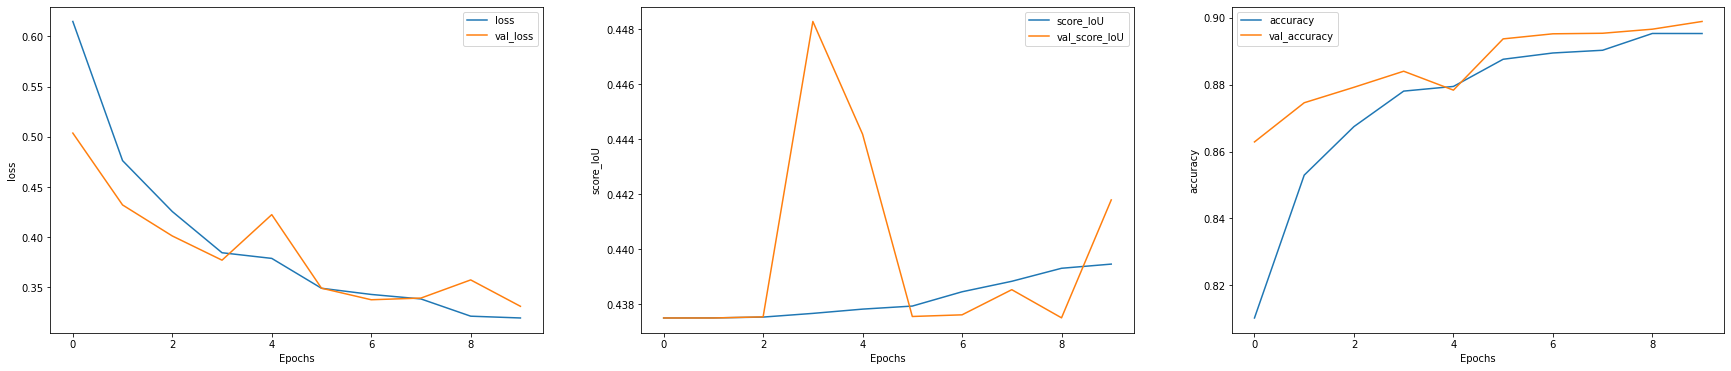

Training time : 13031.569425582886


In [ ]:
print(f'Training for augmented_{model_name}')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}.h5', 
                             save_best_only=True)]

# Train the model
start = time()

model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs,
            loss=None,
            do_augment=True,
            custom_augmentation=custom_augmentation,
            callbacks=callbacks,
            display_history=True)

training_time = time() - start
print(f'Training time : {training_time}')

# Save the model
model.save(model_path+f'/augmented_{model_name}.h5')

## **<font color=green>Evaluer le modèle</font>**

In [ ]:
# Reload result dataframe if necessary
df_result = pd.read_csv(project_path +'/p8_bench_models.csv')

# Evaluate the model
start_eval = time()
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)
eval_time = time() - start_eval
print(f'Evaluation time : {eval_time}')

500it [03:15,  2.56it/s]

Evaluation time : 195.3675365447998


In [ ]:
# Display all results associated to the current model
df_result = model_result_to_dataframe(model_name, epochs, training_time,
                                      eval_time, df_result, model_result,
                                      do_augment=True)
# Save to CSV
df_result.to_csv(project_path +'/p8_bench_models_.csv', index=False)

# Display result
df_result

,model,epoch,training_time,eval_time,freq_weighted_IoU,mean_IoU,void_IoU,flat_IoU,construction_IoU,object_IoU,nature_IoU,sky_IoU,human_IoU,vehicule_IoU
0,fcn_8_mobilenet,10,9142.648268,287.796532,0.816843,0.698853,0.662680,0.918349,0.789160,0.247691,0.827616,0.850066,0.492819,0.802441
1,mobilenet_segnet,10,7079.165533,67.980525,0.818043,0.693237,0.668124,0.920690,0.791111,0.284394,0.826521,0.852850,0.410043,0.792159
2,vgg_unet,10,7080.835249,70.308717,0.832970,0.739881,0.653320,0.923370,0.805230,0.391451,0.858946,0.896825,0.570200,0.819705
3,augmented_mobilenet_segnet,10,13031.569426,195.367537,0.789224,0.650878,0.636084,0.906534,0.758398,0.203882,0.801899,0.795996,0.386695,0.717539


## **<font color=green>Visualiser les prédictions</font>**

[329 345 298 384 353]


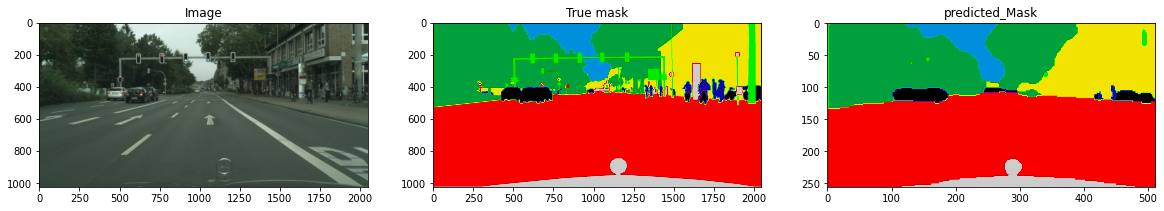

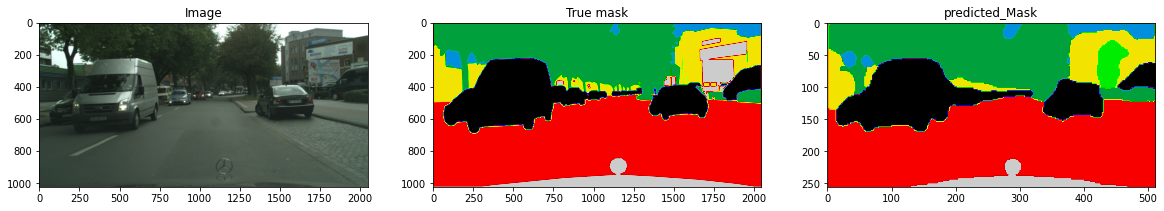

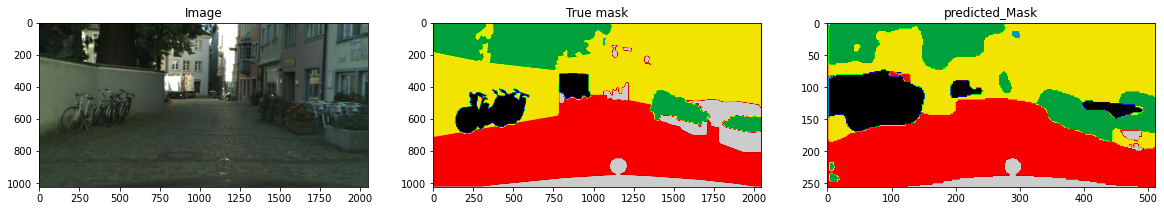

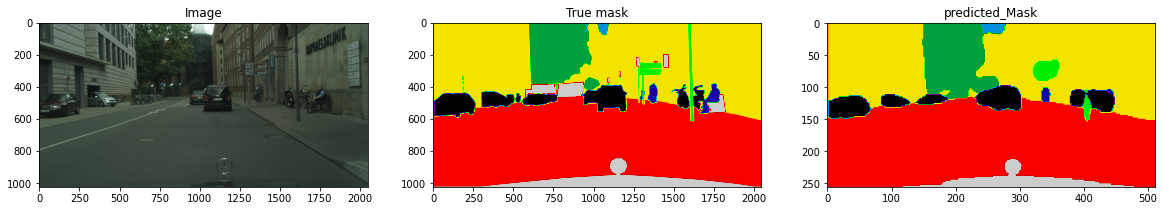

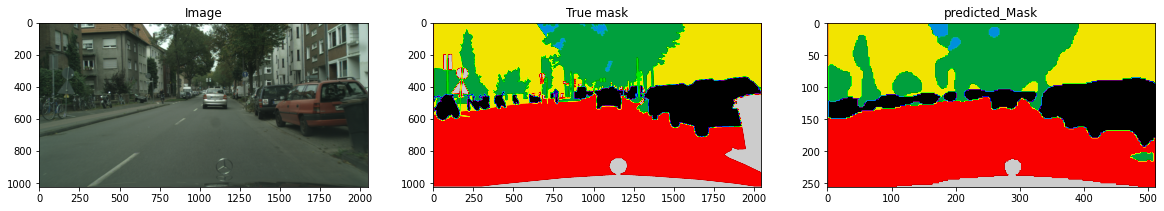

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=True, n=5)

# <font color=salmon>PART 4 - OPTIMISATION DE LA FONCTION DE PERTE</font>

## **<font color=green>Fonctions de perte additionnelles</font>**

In [ ]:
# Function for dice loss
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smooth = 1e-8
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - score

# Function for total loss (dice + cce)
cce = 'categorical_crossentropy'
def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    ttl_loss = cce(y_true, y_pred).numpy() + (3*dice_loss(y_true, y_pred))
    return ttl_loss

## **<font color=green>Sauvegarder les données dans un dataframe</font>**

In [ ]:
# Prepare dataframe to save results
df_loss = pd.DataFrame(columns= ['model_name', 'freq_weighted_IoU', 'mean_IoU'])

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

## **<font color=green>Entraîner le modèle avec Categorical CrossEntropy</font>**

### **Appeler le modèle**

In [ ]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

### **Entraîner le modèle**

In [ ]:
print(f'Training for optimized_{model_name} with Categorical Cross-Entropy')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}_cce.h5', 
                             save_best_only=True)]

# Train the model
model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs_optim,
            loss=None,
            callbacks=callbacks,
            display_history=False)

Training for optimized_mobilenet_segnet with Categorical Cross-Entropy
Verifying training dataset


100%|██████████| 2380/2380 [02:45<00:00, 14.42it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [00:41<00:00, 14.32it/s]


Dataset verified! 
Epoch 1/3
512/512 [==============================] - 693s 1s/step - loss: 0.3328 - score_IoU: 0.4380 - accuracy: 0.8915 - val_loss: 0.3718 - val_score_IoU: 0.4381 - val_accuracy: 0.8822
Epoch 2/3
512/512 [==============================] - 689s 1s/step - loss: 0.2192 - score_IoU: 0.4385 - accuracy: 0.9237 - val_loss: 0.3796 - val_score_IoU: 0.4419 - val_accuracy: 0.9028
Epoch 3/3
512/512 [==============================] - 689s 1s/step - loss: 0.1834 - score_IoU: 0.4404 - accuracy: 0.9350 - val_loss: 0.3186 - val_score_IoU: 0.4455 - val_accuracy: 0.9107


### **Evaluer le modèle**

In [ ]:
# Evaluate the model
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)

model_name = (f'{model_name}_cce')

# Display all results associated to the current model
df_loss = df_loss.append({'model_name':model_name,
                          'freq_weighted_IoU':model_result["frequency_weighted_IU"],
                          'mean_IoU':model_result["mean_IU"]},
                          ignore_index=True)

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

# Display result
df_loss

500it [01:07,  7.36it/s]


,model_name,freq_weighted_IoU,mean_IoU
0,mobilenet_segnet_cce,0.813437,0.69296


### **Visualiser les prédictions**

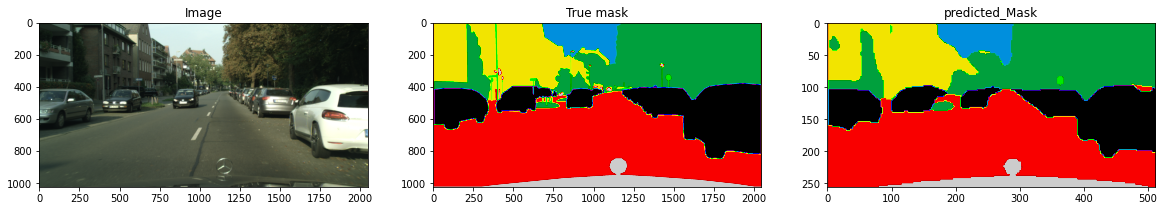

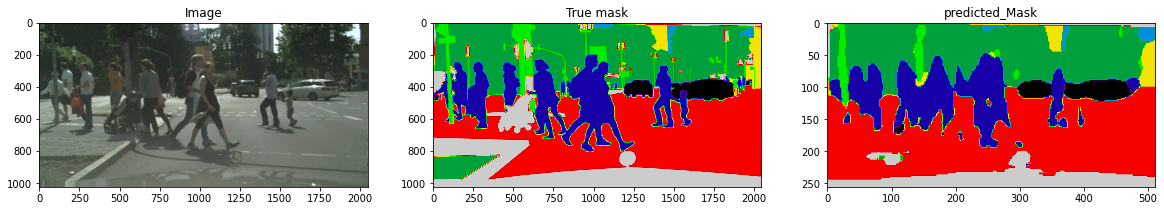

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=False, n=2)

## **<font color=green>Entraîner le modèle avec Dice Loss</font>**

### **Appeler le modèle**

In [ ]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

### **Entraîner le modèle**

In [ ]:
print(f'Training for optimized_{model_name} with Dice Loss')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}_diceLoss.h5', 
                             save_best_only=True)]

# Train the model
model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs_optim,
            loss=dice_loss,
            callbacks=callbacks,
            display_history=False)

Training for optimized_mobilenet_segnet with Dice Loss
Verifying training dataset


100%|██████████| 2380/2380 [02:49<00:00, 14.07it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [00:42<00:00, 14.10it/s]


Dataset verified! 
Epoch 1/3
512/512 [==============================] - 702s 1s/step - loss: 0.1131 - score_IoU: 0.5731 - accuracy: 0.8892 - val_loss: 0.0941 - val_score_IoU: 0.6935 - val_accuracy: 0.9066
Epoch 2/3
512/512 [==============================] - 690s 1s/step - loss: 0.0849 - score_IoU: 0.7420 - accuracy: 0.9157 - val_loss: 0.0916 - val_score_IoU: 0.8487 - val_accuracy: 0.9089
Epoch 3/3
512/512 [==============================] - 689s 1s/step - loss: 0.0762 - score_IoU: 0.8211 - accuracy: 0.9242 - val_loss: 0.0928 - val_score_IoU: 0.8509 - val_accuracy: 0.9076


### **Evaluer le modèle**

In [ ]:
# Evaluate the model
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)

model_name = (f'{model_name}_diceLoss')

# Display all results associated to the current model
df_loss = df_loss.append({'model_name':model_name,
                          'freq_weighted_IoU':model_result["frequency_weighted_IU"],
                          'mean_IoU':model_result["mean_IU"]},
                          ignore_index=True)

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

# Display result
df_loss

500it [01:07,  7.39it/s]


,model_name,freq_weighted_IoU,mean_IoU
0,mobilenet_segnet_cce,0.813437,0.692960
1,mobilenet_segnet_diceLoss,0.803624,0.653009


### **Visualiser les prédictions**

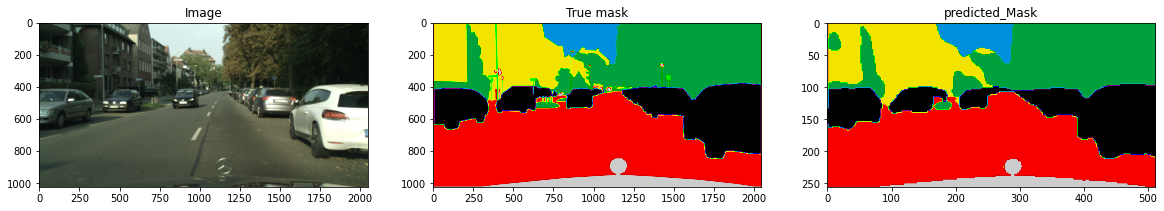

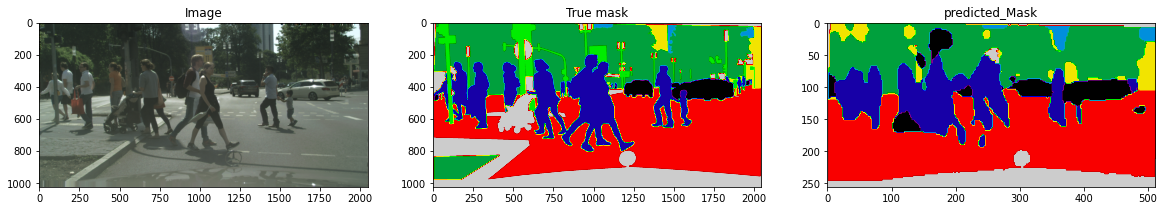

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=False, n=2)

## **<font color=green>Entraîner le modèle avec Total Loss</font>**

### **Appeler le modèle**

In [ ]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

### **Entraîner le modèle**

In [ ]:
print(f'Training for optimized_{model_name} with Total Loss (CCE + DiceLosse')

# Set checkpoints
callbacks = [ModelCheckpoint(checkpoint_path +f'/{model_name}_ttlLoss.h5', 
                             save_best_only=True)]

# Train the model
model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=epochs_optim,
            loss=dice_loss,
            callbacks=callbacks,
            display_history=False)

Training for optimized_mobilenet_segnet with Total Loss (CCE + DiceLosse
Verifying training dataset


100%|██████████| 2380/2380 [02:48<00:00, 14.15it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [00:42<00:00, 14.06it/s]


Dataset verified! 
Epoch 1/3
512/512 [==============================] - 698s 1s/step - loss: 0.1147 - score_IoU: 0.6154 - accuracy: 0.8876 - val_loss: 0.1040 - val_score_IoU: 0.6989 - val_accuracy: 0.8970
Epoch 2/3
512/512 [==============================] - 693s 1s/step - loss: 0.0914 - score_IoU: 0.7274 - accuracy: 0.9091 - val_loss: 0.0952 - val_score_IoU: 0.7909 - val_accuracy: 0.9052
Epoch 3/3
512/512 [==============================] - 691s 1s/step - loss: 0.0838 - score_IoU: 0.8030 - accuracy: 0.9166 - val_loss: 0.0975 - val_score_IoU: 0.8037 - val_accuracy: 0.9028


### **Evaluer le modèle**

In [ ]:
# Evaluate the model
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)

model_name = (f'{model_name}_ttlLoss')

# Display all results associated to the current model
df_loss = df_loss.append({'model_name':model_name,
                          'freq_weighted_IoU':model_result["frequency_weighted_IU"],
                          'mean_IoU':model_result["mean_IU"]},
                          ignore_index=True)

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

# Display result
df_loss

500it [01:06,  7.48it/s]


,model_name,freq_weighted_IoU,mean_IoU
0,mobilenet_segnet_cce,0.813437,0.692960
1,mobilenet_segnet_diceLoss,0.803624,0.653009
2,mobilenet_segnet_ttlLoss,0.796490,0.595417


### **Visualiser les prédictions**

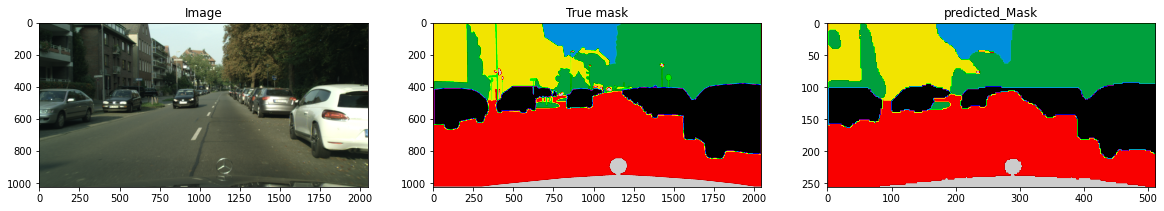

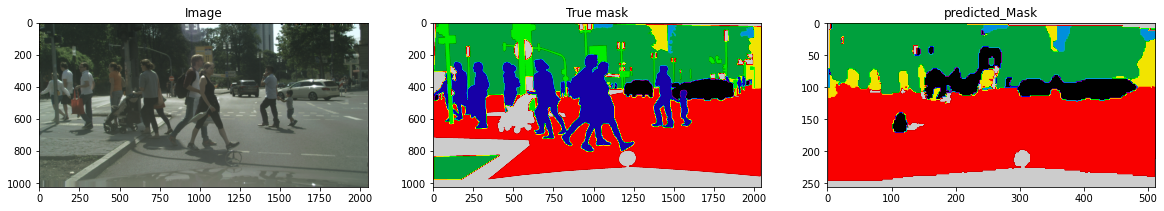

In [ ]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=False, n=2)

## **<font color=green>Entraîner le modèle final avec 50 epoch et earlystopping</font>**

### **Appeler le modèle**

In [9]:
# Clear previous session
K.clear_session()

# Name next model to benchmark
model_name= 'mobilenet_segnet'

# Call the model
model = mobilenet_segnet(n_classes=n_classes,
                         input_height=img_height,
                         input_width=img_width)

17235968/17225924 [==============================] - 0s 0us/step


### **Entraîner le modèle**

Training for optimized_mobilenet_segnet with cce & earlystop
Verifying training dataset


100%|██████████| 2380/2380 [14:33<00:00,  2.73it/s]


Dataset verified! 
Verifying validation dataset


100%|██████████| 595/595 [03:28<00:00,  2.85it/s]


Dataset verified! 
Epoch 1/50
512/512 [==============================] - 692s 1s/step - loss: 0.3322 - score_IoU: 0.4375 - accuracy: 0.8918 - val_loss: 0.3160 - val_score_IoU: 0.4375 - val_accuracy: 0.9021
Epoch 2/50
512/512 [==============================] - 674s 1s/step - loss: 0.2117 - score_IoU: 0.4382 - accuracy: 0.9260 - val_loss: 0.3255 - val_score_IoU: 0.4507 - val_accuracy: 0.9062
Epoch 3/50
512/512 [==============================] - 672s 1s/step - loss: 0.1843 - score_IoU: 0.4399 - accuracy: 0.9345 - val_loss: 0.3483 - val_score_IoU: 0.4530 - val_accuracy: 0.9042
Epoch 4/50
512/512 [==============================] - 678s 1s/step - loss: 0.1604 - score_IoU: 0.4437 - accuracy: 0.9423 - val_loss: 0.3560 - val_score_IoU: 0.4501 - val_accuracy: 0.9140
Epoch 5/50
512/512 [==============================] - 680s 1s/step - loss: 0.1484 - score_IoU: 0.4476 - accuracy: 0.9460 - val_loss: 0.3874 - val_score_IoU: 0.4553 - val_accuracy: 0.9024
Epoch 6/50
512/512 [==========================

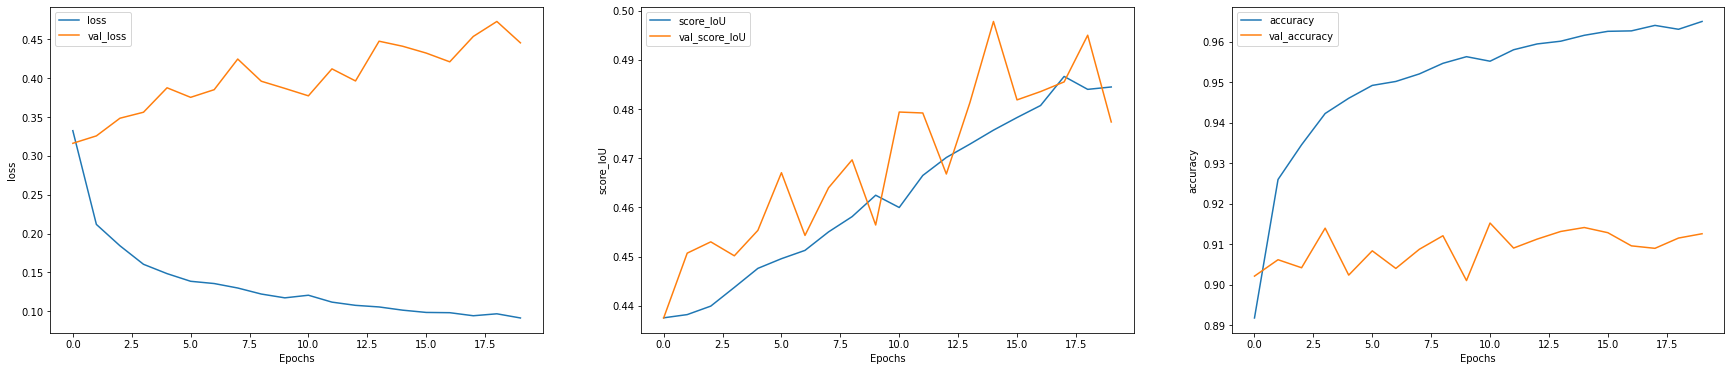

In [10]:
print(f'Training for optimized_{model_name} with cce & earlystop')

#Set Early Stopping
earlystop = tf.keras.callbacks.EarlyStopping(mode='max', monitor='val_score_IoU', patience=5, verbose=1)

# Set checkpoints
callbacks = [earlystop, ModelCheckpoint(checkpoint_path +f'/{model_name}_cce_final.h5', save_best_only=True)]

# Train the model
model.train(train_images = train_input_dir,
            train_annotations = train_target_dir,
            batch_size = batch_size,
            input_height=img_height,
            input_width=img_width,
            n_classes=n_classes,
            validate=True,
            val_images=val_input_dir,
            val_annotations=val_target_dir, 
            epochs=50,
            loss=None,
            callbacks=callbacks,
            display_history=True)

### **Evaluer le modèle**

In [11]:
# Evaluate the model
model_result = model.evaluate_segmentation(inp_images_dir=test_input_dir,
                                           annotations_dir=test_target_dir)

model_name = (f'{model_name}_cce_earlystop')

df_loss = pd.read_csv(project_path +'/p8_bench_loss.csv')

# Display all results associated to the current model
df_loss = df_loss.append({'model_name':model_name,
                          'freq_weighted_IoU':model_result["frequency_weighted_IU"],
                          'mean_IoU':model_result["mean_IU"]},
                          ignore_index=True)

# Save to CSV
df_loss.to_csv(project_path +'/p8_bench_loss.csv', index=False)

# Display result
df_loss

500it [04:11,  1.99it/s]


,model_name,freq_weighted_IoU,mean_IoU
0,mobilenet_segnet_cce,0.813437,0.692960
1,mobilenet_segnet_diceLoss,0.803624,0.653009
2,mobilenet_segnet_ttlLoss,0.796490,0.595417
3,mobilenet_segnet_cce_earlystop,0.817391,0.704822


### **Visualiser les prédictions**

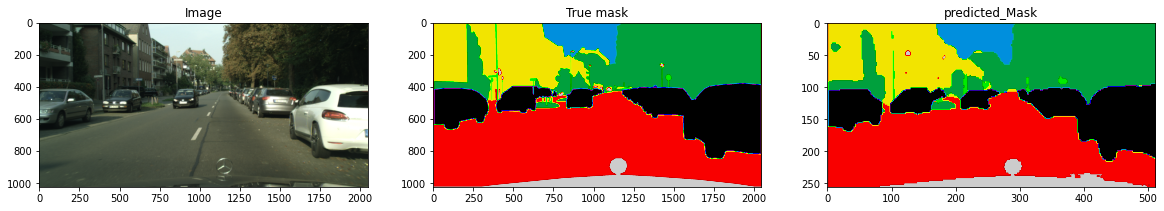

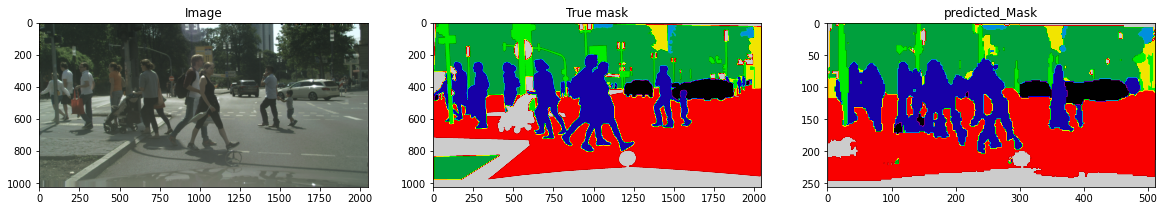

In [12]:
# Plot image, mask and prediction
plot_image_mask_prediction(test_input_path, test_target_path, 
                           img_height, img_width, random=False, n=2)

### **Conclusion sur les fonctions de perte**

Après optimisation, il s'avère que les fonctions de perte **Dice Loss** et la combinaison du **Categorical Cross-Entropy et du Dice Loss en tant que Total Loss** n'améliore pas les performances du modèle.

Nous gardons donc la fonction de perte : <font color=green>**Categorical Cross-Entropy**</font>, qui semble être très bien adaptée à nos données.